# Merger fractions against galaxy separation for volume limited Galaxy Zoo 1 and Galaxy Zoo 2 sample

In this notebook we use Galaxy Zoo 1 (GZ1) and Galaxy Zoo 2 (GZ2) data which has been matched to group data from Yang. We calculate the separation of the nearest neighbour within a group for each galaxy and plot the merger fraction against separatino. We bin our data by attempting to have the same number of galaxies in each bin.

For this notebook we volume limit our sample of galaxies, recalculating the group size for galaxies in the volume limit.

The GZ1 and GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 (DR7) of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/
<br>
The Yang group data can be found at https://gax.sjtu.edu.cn/data/Group.html

#### Data
There are 4 different data sets we are using from the GZ data page. For GZ1 we are using "Table 2", which are galaxies from the entire GZ1 data set with spectra available in SDSS DR7 and "Table 3", which are galaxies from the entire GZ1 data set with no spectra available in SDSS DR7. These have 667,944 and 225,268 galaxies in them respectively.
<br>
For GZ1 we are using "Table 5", which are galaxies from the main GZ2 sample spectroscopic redshifts available in SDSS DR7 and "Table 6", which are galaxies from the main GZ2 sample with only photometric redshifts available in SDSS DR7. These have 243,500 and 42,462 galaxies in them respectively.
<br>
We use Yang Catalogue "PetroC" containing 639,359 galaxies and 473,872 groups.

#### Matching GZ1, GZ2 and Yang
The Yang data set covers redshifts $0.01 \leq z \leq 0.2$, whereas GZ1 and GZ2 cover a greater redshift range. Hence we expect to lose some galaxies when we match the GZ1&2 data to the Yang catalogue. We match the GZ1&2 data to the Yang data by right-ascension (ra) and declination (dec) with a maximum error in position of 5 arcsec, preferentially choosing galaxies with spectra available if both a galaxy from the spectroscopic data and from the photometric data match to the same Yang galaxy.

The total number of matches in Yang for each of the 4 galaxy zoo data sets are:

- GZ1 spectroscopic: 586,594 galaxies
- GZ1 photometric: 42,197 galaxies
- GZ2 spectroscopic: 233,767 galaxies
- GZ2 photometric: 19,451 galaxies

In total there are 628,791 galaxies in Yang with GZ1 data and 253,218 galaxies in Yang with GZ2 data, with 629,365 galaxies from Yang having either GZ1 or GZ2 data and 252,644 galaxies with both GZ1 and GZ2 data.

From now on we shall refer to the Yang group data set of 639,359 galaxies as Yang, and the matched GZ1&2 and Yang data sets as GZ1 and GZ2.

### Importing the data
First we import the necessary packages and import the data into an Astropy Table "all_data".

We display the head of the table to get an idea of what the data looks like.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import .fits data as a table
data_filename = "E:\\MPhys Project\\Main Data\\Group_GZ1_GZ2_full_new_best_z_and_Mr_fixed_groups.fits" # All galaxies in group data set with matched GZ1 & Gz2 galaxies

with fits.open(data_filename) as data:
    all_data = Table(data[1].data)

# Display head of data
display(all_data[0:5])

galaxy ID,NYU-VAGC ID object ID,ra_galaxy,dec_galaxy,z_galaxy,apparent magnitude r_band,magnitude limit r_band,completeness,col9 Petro,col10 Petro,col11 Model,col12 Model,redshift source type,group id,brightest galaxy,most massive galaxy,RA_group,dec_group,z_group,group L_-19.5 log L_odoth2,group stellar mass,halo mass1,halo mass2,mean separation brighter,mean separation massive,f_edge,ID1,ID2,group_size,OBJID_GZ1,RA_GZ1,DEC_GZ1,NVOTE_GZ1,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN,U_GZ1,G_GZ1,R_GZ1,I_GZ1,Z_GZ1,UERR_GZ1,GERR_GZ1,RERR_GZ1,IERR_GZ1,ZERR_GZ1,R50_ARCSEC_GZ1,R90_ARCSEC_GZ1,REDSHIFT_GZ1,REDSHIFTERR_GZ1,REDSHIFTCONF_GZ1,MU_GZ1,MG_GZ1,MR_GZ1,MI_GZ1,MZ_GZ1,MUERR_GZ1,MGERR_GZ1,MRERR_GZ1,MIERR_GZ1,MZERR_GZ1,R50_KPC_GZ1,specobjid_GZ2,dr8objid_GZ2,dr7objid_GZ2,ra_GZ2,dec_GZ2,rastring_GZ2,decstring_GZ2,sample_GZ2,gz2class,total_classifications_GZ2,total_votes_GZ2,t01_smooth_or_features_a01_smooth_count,t01_smooth_or_features_a01_smooth_weight,t01_smooth_or_features_a01_smooth_fraction,t01_smooth_or_features_a01_smooth_weighted_fraction,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a01_smooth_flag,t01_smooth_or_features_a02_features_or_disk_count,t01_smooth_or_features_a02_features_or_disk_weight,t01_smooth_or_features_a02_features_or_disk_fraction,t01_smooth_or_features_a02_features_or_disk_weighted_fraction,t01_smooth_or_features_a02_features_or_disk_debiased,t01_smooth_or_features_a02_features_or_disk_flag,t01_smooth_or_features_a03_star_or_artifact_count,t01_smooth_or_features_a03_star_or_artifact_weight,t01_smooth_or_features_a03_star_or_artifact_fraction,t01_smooth_or_features_a03_star_or_artifact_weighted_fraction,t01_smooth_or_features_a03_star_or_artifact_debiased,t01_smooth_or_features_a03_star_or_artifact_flag,t02_edgeon_a04_yes_count,t02_edgeon_a04_yes_weight,t02_edgeon_a04_yes_fraction,t02_edgeon_a04_yes_weighted_fraction,t02_edgeon_a04_yes_debiased,t02_edgeon_a04_yes_flag,t02_edgeon_a05_no_count,t02_edgeon_a05_no_weight,t02_edgeon_a05_no_fraction,t02_edgeon_a05_no_weighted_fraction,t02_edgeon_a05_no_debiased,t02_edgeon_a05_no_flag,t03_bar_a06_bar_count,t03_bar_a06_bar_weight,t03_bar_a06_bar_fraction,t03_bar_a06_bar_weighted_fraction,t03_bar_a06_bar_debiased,t03_bar_a06_bar_flag,t03_bar_a07_no_bar_count,t03_bar_a07_no_bar_weight,t03_bar_a07_no_bar_fraction,t03_bar_a07_no_bar_weighted_fraction,t03_bar_a07_no_bar_debiased,t03_bar_a07_no_bar_flag,t04_spiral_a08_spiral_count,t04_spiral_a08_spiral_weight,t04_spiral_a08_spiral_fraction,t04_spiral_a08_spiral_weighted_fraction,t04_spiral_a08_spiral_debiased,t04_spiral_a08_spiral_flag,t04_spiral_a09_no_spiral_count,t04_spiral_a09_no_spiral_weight,t04_spiral_a09_no_spiral_fraction,t04_spiral_a09_no_spiral_weighted_fraction,t04_spiral_a09_no_spiral_debiased,t04_spiral_a09_no_spiral_flag,t05_bulge_prominence_a10_no_bulge_count,t05_bulge_prominence_a10_no_bulge_weight,t05_bulge_prominence_a10_no_bulge_fraction,t05_bulge_prominence_a10_no_bulge_weighted_fraction,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a10_no_bulge_flag,t05_bulge_prominence_a11_just_noticeable_count,t05_bulge_prominence_a11_just_noticeable_weight,t05_bulge_prominence_a11_just_noticeable_fraction,t05_bulge_prominence_a11_just_noticeable_weighted_fraction,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a11_just_noticeable_flag,t05_bulge_prominence_a12_obvious_count,t05_bulge_prominence_a12_obvious_weight,t05_bulge_prominence_a12_obvious_fraction,t05_bulge_prominence_a12_obvious_weighted_fraction,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a12_obvious_flag,t05_bulge_prominence_a13_dominant_count,t05_bulge_prominence_a13_dominant_weight,t05_bulge_prominence_a13_dominant_fraction,t05_bulge_prominence_a13_dominant_weighted_fraction,t05_bulge_prominence_a13_dominant_debiased,t05_bulge_prominence_a13_dominant_flag,t06_odd_a14_yes_count,t06_odd_a14_yes_weight,t06_odd_a14_yes_fraction,t

### Classifying mergers
Many of the galaxies in our data set have classification data from both GZ1 and GZ2. As GZ1 and GZ2 have different decision trees, we must classify mergers in a different way for each. We can then compare the classifications for galaxies which are in both sets, to see if our classification methods are consistent.

For GZ1 we will use the threshold for merger classification as described in [Darg et al. (2009)](https://arxiv.org/pdf/0903.4937.pdf):
- merger weighted vote fraction $p_m$ > 0.4

Note that this was used in Darg et al. (2009) for only galaxies with redshifts $0.005 < z < 0.1$, but we will use it for galaxies in the range $0.1 \leq z \leq 0.2$ here also.

For GZ2 we will use the threshold for merger classification we have done previously:
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4

In [2]:
# Create a new column in the data for GZ1 mergers, with a value of 1 if the galaxy is classified as a merger, and 0 if not
all_data_pandas = all_data.to_pandas()
all_data_pandas["GZ1_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ1"] == 1) & (all_data_pandas["P_MG"] > 0.4), "GZ1_merger_yes"] = 1

# Do the same for GZ2 mergers
all_data_pandas["GZ2_merger_yes"] = 0
all_data_pandas.loc[(all_data_pandas["GZ2"] == 1) & (all_data_pandas["t06_odd_a14_yes_count"] >= 20) & (all_data_pandas["t06_odd_a14_yes_debiased"] > 0.42) & (all_data_pandas["t08_odd_feature_a24_merger_count"] >= 10) & (all_data_pandas["t08_odd_feature_a24_merger_debiased"] > 0.4), "GZ2_merger_yes"] = 1

# Return data frame
all_data = Table.from_pandas(all_data_pandas)

# Add column that gives number of merger classifications
all_data["Merger_classifications"] = all_data["GZ1_merger_yes"] + all_data["GZ2_merger_yes"]

### Volume limiting

We use the volume limit we have done in previous notebooks: $M_r < -19$, $0.01 < z_\text{mean} < 0.05$, where $M_r$ is the absolute magnitude and $z_\text{mean}$ is the mean redshift of galaxies in a group with $M_r < -19$.

We import the mean group redshifts and velocity data for galaxies in this volume limit below, then identify which galaxies are in our volume limit.

In [3]:
# Read previously calculated mean z for volume limited groups
volume_limited_mean_z_filename = "E:\\MPhys Project\\Main Data\\mean_redshift_Mr_less_than_19.fits"

with fits.open(volume_limited_mean_z_filename) as data:
    volume_limited_mean_z = Table(data[1].data)

# Crate pandas DataFrames to merge
all_data_pandas = all_data.to_pandas()
volume_limited_mean_z_pandas = volume_limited_mean_z.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
merged = pd.merge(all_data_pandas, volume_limited_mean_z_pandas, on="galaxy ID", how="left")

# Make mean of N=1 groups equal to galaxy redshift
merged.loc[merged["group_size_new"] == 1, "z_group_mean"] = merged.loc[merged["group_size_new"] == 1, "Best_redshift_new"]

# Read previously calculated mean z for volume limited groups
velocities_filename = "E:\\MPhys Project\\Main Data\\velocity_data_volume_limited.fits"

with fits.open(velocities_filename) as data:
    velocity_data_to_merge = Table(data[1].data)

# Crate pandas DataFrames to merge
velocity_data_to_merge_pandas = velocity_data_to_merge.to_pandas()

# Merge the two DataFrames, keeping all the rows in the full DataFrame
velocities_merged = pd.merge(merged, velocity_data_to_merge_pandas, on="galaxy ID", how="left")

# Make copy of data
all_data_pandas = velocities_merged.copy()

# Create column for identifying galaxies in volume limit
all_data_pandas["volume_limited_sample"] = 0

# Set volume_limited_sample == 1 if galaxy is in volume limit
all_data_pandas.loc[(all_data_pandas["Best_Mr_new"] < -19) & (all_data_pandas["z_group_mean"] < 0.05), "volume_limited_sample"] = 1

# Print information about number of galaxies in volume limit
print("Number of galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"])))
print("Fraction of all galaxies in volume limit: " + str(sum(all_data_pandas["volume_limited_sample"]) / len(all_data_pandas)))
print("Number of mergers in volume limit: " + str(len(all_data_pandas[(all_data_pandas["volume_limited_sample"] == 1) & (all_data_pandas["Merger_classifications"] >= 1)])))

Number of galaxies in volume limit: 67647
Fraction of all galaxies in volume limit: 0.1058044072266129
Number of mergers in volume limit: 2059


### Volume limited groups
Now that we have volume limited our sample, we would like to calculate the number of galaxies that are in the volume limit in each group, or the number of galaxies with $M_r < -19$ in each group. We are only interested in groups for which at least one member has either GZ1 or GZ2 data. If a group does not have any GZ data then we have no morphological information about any of its members and should not be included in the following analysis.

We add a column to our data below containing the number of galaxies in each group that are in the volume limited sample.

In [4]:
# Group by group id and count the number of galaxies in each group in volume limit
volume_limited_galaxies_in_group = all_data_pandas.groupby("group_id_new")["volume_limited_sample"].sum()
volume_limited_galaxies_in_group.rename("volume_limited_galaxies_in_group", inplace=True)

# Merge group size for volume limited groups with main data table
all_data_pandas = pd.merge(all_data_pandas, volume_limited_galaxies_in_group, on="group_id_new", how="left")

# Choose only galaxies in volume limit
volume_limited_groups = all_data_pandas[all_data_pandas["volume_limited_sample"] == 1].copy()

# Add column with value = 0 if the galaxy does not have GZ data, value = 1 if the galaxy does have GZ data
volume_limited_groups["GZ"] = 0
volume_limited_groups.loc[(volume_limited_groups["GZ1"] == 1) | (volume_limited_groups["GZ2"] == 1), "GZ"] = 1

# Count the number of galaxies in each group in the volume limit that have Galaxy Zoo data
volume_limited_groups_GZ_galaxies = volume_limited_groups.groupby("group_id_new")["GZ"].sum()
volume_limited_groups_GZ_galaxies.rename("GZ_galaxies_in_group", inplace=True)
volume_limited_groups_GZ_galaxies

volume_limited_groups = pd.merge(volume_limited_groups, volume_limited_groups_GZ_galaxies, on="group_id_new", how="left")

# Remove any groups from the volume limit which we have no GZ data for
volume_limited_groups = volume_limited_groups[volume_limited_groups["GZ_galaxies_in_group"] > 0].copy()

## Merger fraction of each group

For each group, we will calculate the merger fraction by finding the fraction of galaxies that are merging in each group.

In [5]:
volume_limited_data = volume_limited_groups.copy()

In [6]:
# Select only needed columns
groups_data_greater_than_1 = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] > 1][["galaxy ID", "group_id_new", "volume_limited_galaxies_in_group", "Merger_classifications"]].copy()
# Groupby galaxy group id, creating a dictrionary with group id as the key, and the indicies of the galaxies as values
groups_data_greater_than_1 = groups_data_greater_than_1.reset_index()
groups = groups_data_greater_than_1.groupby("group_id_new").indices

# Add the new desired columns to the DataFrame
groups_data_greater_than_1["Mergers_in_group"] = 0
groups_data_greater_than_1["group_merger_fraction"] = 0

# Print the number of groups the calculation must be done for
print("Number of groups to calculate for: " + str(len(groups)))
i = 1

for key, values in groups.items(): # Iterate over the dictionary of group ids
    
    # Count number of mergers in group
    individual_group = groups_data_greater_than_1.loc[values].copy()
    groups_data_greater_than_1.loc[values, "Mergers_in_group"] = len(individual_group[individual_group["Merger_classifications"] > 0])
    groups_data_greater_than_1.loc[values, "group_merger_fraction"] = groups_data_greater_than_1.loc[values[0], "Mergers_in_group"] / len(individual_group)
    
    # Progress checker
    if i % 2000 == 0:
        print("Progress: " + str(i) + " groups done")
    elif i == len(groups):
        print("Progress: Done")
    i += 1

Number of groups to calculate for: 7035
Progress: 2000 groups done
Progress: 4000 groups done
Progress: 6000 groups done
Progress: Done


In [7]:
groups_data_greater_than_1_needed = groups_data_greater_than_1[["galaxy ID", "Mergers_in_group", "group_merger_fraction"]].copy()
groups_data = pd.merge(volume_limited_data, groups_data_greater_than_1_needed, how="left", on="galaxy ID")

groups_data.loc[groups_data["volume_limited_galaxies_in_group"] == 1, "Mergers_in_group"] = groups_data.loc[groups_data["volume_limited_galaxies_in_group"] == 1, "Merger_classifications"]
groups_data.loc[(groups_data["volume_limited_galaxies_in_group"] == 1) & (groups_data["Merger_classifications"] == 2), "Merger_classifications"] = 1
groups_data.loc[groups_data["volume_limited_galaxies_in_group"] == 1, "group_merger_fraction"] = groups_data.loc[groups_data["volume_limited_galaxies_in_group"] == 1, "Mergers_in_group"]
groups_data["Mergers_in_group"] = groups_data["Mergers_in_group"].astype(int)

volume_limited_data = groups_data.copy()

## $N=2$ groups separation

Below we only consider groups with 2 members. We calculate the 2d separation between a galaxy and it's nearest neighbour (not necessarily the other galaxy in the group) and the 3d separation using distances estimated by redshifts.

In [8]:
from astropy.cosmology import Planck18_arXiv_v2
from astropy.coordinates import SkyCoord
from astropy import units as u

In [9]:
# Select only N=2 groups
n_equals_2_groups = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] == 2][["galaxy ID", "group_id_new", "ra_galaxy", "dec_galaxy", "Best_redshift_new", "Merger_classifications"]].copy()
n_equals_2_groups = n_equals_2_groups.reset_index()
n_equals_2_groups["Distance"] = Planck18_arXiv_v2.comoving_distance(n_equals_2_groups["Best_redshift_new"]).value

# Add the new desired columns to the DataFrame
n_equals_2_groups["Nearest_neighbour_separation_2d_working"] = 0
n_equals_2_groups["Nearest_galaxy_id"] = 0
n_equals_2_groups["Nearest_neighbour_separation_2d"] = 0
n_equals_2_groups["Nearest_neighbour_separation_3d"] = 0

# Print the number of groups the calculation must be done for
print("Number of galaxies to calculate for: " + str(len(n_equals_2_groups)))

for i in range(len(n_equals_2_groups)):
    
    galaxy_i = pd.DataFrame(n_equals_2_groups.loc[i]).transpose()
    galaxy_i_sky_coord = SkyCoord(ra=galaxy_i["ra_galaxy"].values*u.degree, dec=galaxy_i["dec_galaxy"].values*u.degree, distance=galaxy_i["Distance"].values*u.Mpc)
    
    n_equals_2_groups.loc[~n_equals_2_groups.index.isin([i]), "Nearest_neighbour_separation_2d_working"] = galaxy_i_sky_coord.separation( SkyCoord(ra=n_equals_2_groups.loc[~n_equals_2_groups.index.isin([i]), "ra_galaxy"].values*u.degree, dec=n_equals_2_groups.loc[~n_equals_2_groups.index.isin([i]), "dec_galaxy"].values*u.degree) ).to(u.arcsecond).value
    
    not_galaxy_i = n_equals_2_groups.loc[~n_equals_2_groups.index.isin([i])]
    min_index = not_galaxy_i.loc[not_galaxy_i["Nearest_neighbour_separation_2d_working"] == not_galaxy_i["Nearest_neighbour_separation_2d_working"].min()].index
    
    n_equals_2_groups.loc[i, "Nearest_galaxy_id"] = n_equals_2_groups.loc[min_index, "galaxy ID"].values
    n_equals_2_groups.loc[i, "Nearest_neighbour_separation_2d"] = n_equals_2_groups.loc[min_index, "Nearest_neighbour_separation_2d_working"].values
    min_sep_sky_coord = SkyCoord(ra=n_equals_2_groups.loc[min_index, "ra_galaxy"].values*u.degree, dec=n_equals_2_groups.loc[min_index, "dec_galaxy"].values*u.degree, distance=n_equals_2_groups.loc[min_index, "Distance"].values*u.Mpc)
    n_equals_2_groups.loc[i, "Nearest_neighbour_separation_3d"] = galaxy_i_sky_coord.separation_3d(min_sep_sky_coord).to(u.Mpc).value
    
    # Progress checker
    if i % 2000 == 0:
        print("Progress: " + str(i) + " galaxies done")
    elif i == (len(n_equals_2_groups) - 1):
        print("Progress: Done")
    i += 1

Number of galaxies to calculate for: 8670
Progress: 0 galaxies done
Progress: 2000 galaxies done
Progress: 4000 galaxies done
Progress: 6000 galaxies done
Progress: 8000 galaxies done
Progress: Done


In [10]:
testing = n_equals_2_groups[n_equals_2_groups["group_id_new"] == np.random.choice(np.unique(n_equals_2_groups["group_id_new"]))]
display(testing[["galaxy ID", "group_id_new", "Nearest_galaxy_id", "Nearest_neighbour_separation_2d", "Nearest_neighbour_separation_2d"]])

testing = testing.reset_index()

c1 = SkyCoord(ra=testing.loc[0, "ra_galaxy"]*u.degree, dec=testing.loc[0, "dec_galaxy"]*u.degree, distance=testing.loc[0, "Distance"]*u.Mpc)
display(c1)

c2 = SkyCoord(ra=testing.loc[1, "ra_galaxy"]*u.degree, dec=testing.loc[1, "dec_galaxy"]*u.degree, distance=testing.loc[1, "Distance"]*u.Mpc)
display(c2)

display(c1.separation(c2).to(u.arcsecond))

display(c1.separation_3d(c2))

,galaxy ID,group_id_new,Nearest_galaxy_id,Nearest_neighbour_separation_2d,Nearest_neighbour_separation_2d
7643,563378,62574,563380,215.550186,215.550186
7644,563380,62574,563378,215.550186,215.550186


<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (162.04491324, 22.25029437, 201.50170792)>

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, Mpc)
    (162.08992635, 22.20729646, 202.14606259)>

<Angle 215.5501862 arcsec>

<Distance 0.67799379 Mpc>

### Histograms of 2D/3D separation

We plot histograms of the calculated 2d and 3d separations to get an idea of how separations are spread.

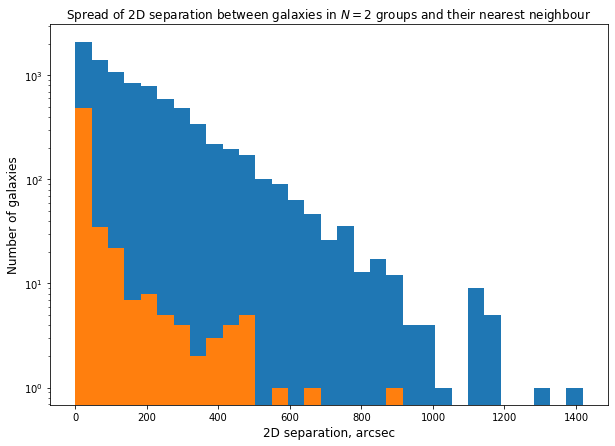

In [31]:
plt.figure(figsize=(10,7))
bins_2d = np.arange(0, 1.05, 1 / 30) * max(n_equals_2_groups["Nearest_neighbour_separation_2d"])
plt.hist(n_equals_2_groups["Nearest_neighbour_separation_2d"], bins=bins_2d, label="All N=2 galaxies")
plt.hist(n_equals_2_groups[n_equals_2_groups["Merger_classifications"] > 0]["Nearest_neighbour_separation_2d"], bins=bins_2d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("2D separation, arcsec", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 2D separation between galaxies in $N=2$ groups and their nearest neighbour", fontsize=12)
plt.show()

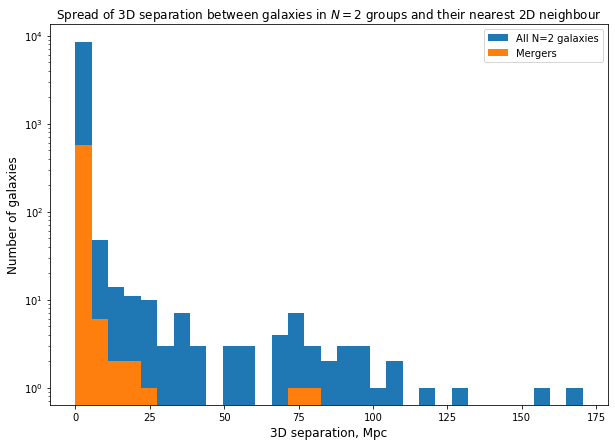

In [37]:
plt.figure(figsize=(10,7))
bins_3d = np.arange(0, 1.05, 1 / 30) * max(n_equals_2_groups["Nearest_neighbour_separation_3d"])
plt.hist(n_equals_2_groups["Nearest_neighbour_separation_3d"], bins=bins_3d, label="All N=2 galaxies")
plt.hist(n_equals_2_groups[n_equals_2_groups["Merger_classifications"] > 0]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 3D separation between galaxies in $N=2$ groups and their nearest 2D neighbour", fontsize=12)
plt.legend()
plt.show()

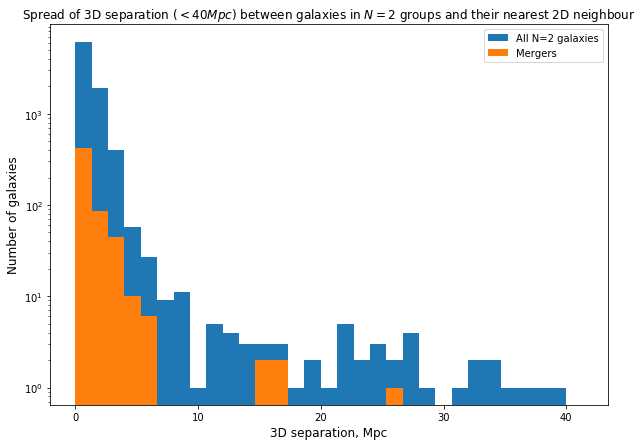

In [38]:
plt.figure(figsize=(10,7))
bins_3d = np.arange(0, 1.05, 1 / 30) * 40
plt.hist(n_equals_2_groups[n_equals_2_groups["Nearest_neighbour_separation_3d"] < 40]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="All N=2 galaxies")
plt.hist(n_equals_2_groups[(n_equals_2_groups["Nearest_neighbour_separation_3d"] < 40) & (n_equals_2_groups["Merger_classifications"] > 0)]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 3D separation ($< 40 Mpc$) between galaxies in $N=2$ groups and their nearest 2D neighbour", fontsize=12)
plt.legend()
plt.show()

## Merger fraction vs 2D separation

We now calculate hwo the merger fraction changes with the 2D separation between galaxies in $N=2$ groups.

Bins: [2.64546385e-02 1.89430267e+01 3.88031411e+01 5.66179043e+01
 8.93693148e+01 1.24728227e+02 1.70204625e+02 2.18604794e+02
 2.83939249e+02 3.93495793e+02 1.37284075e+03]


,Average separation in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,10.504171,0.397924,867,434
1,29.291698,0.134793,868,435
2,46.956667,0.036952,866,433
3,72.189196,0.025375,867,434
4,107.196091,0.019608,867,432
5,147.446346,0.012687,867,430
6,194.344936,0.006920,867,437
7,246.747397,0.009217,868,431
8,330.553880,0.009238,866,435
9,551.445307,0.014994,867,434


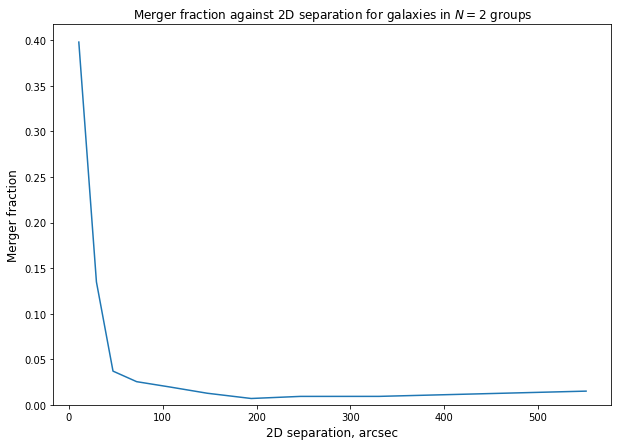

In [43]:
# Create logarithmic bins of equal size without small groups
separation_2d = n_equals_2_groups["Nearest_neighbour_separation_2d"]
equal_log_bins = pd.qcut(x=np.log10(separation_2d), q=10, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
# equal_log_bins = np.round(equal_log_bins, 0)

# Print the bins that have been calculated
print("Bins: " + str(equal_log_bins))


# plt.figure(figsize=(12,8))
# # Plot histogram of group size using logarithmic bins
# plt.hist(separation_2d, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
# plt.xscale("log")
# # plt.yscale("log")
# plt.ylim(bottom=0)
# plt.xlabel("Size of group", fontsize=12)
# plt.ylabel("Number of galaxies", fontsize=12)
# plt.title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)
# plt.show()


# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_separation_2d_binning(limited_data, separation_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Nearest_neighbour_separation_2d", "Merger_classifications", "group_id_new"]]
    
    groups_unique = limited_data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Nearest_neighbour_separation_2d"], bins=separation_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["Nearest_neighbour_separation_2d"], bins=separation_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Nearest_neighbour_separation_2d"], bins=separation_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    bin_edges[-1] += 1
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Nearest_neighbour_separation_2d"] >= bin_edges[i]) & (limited_data["Nearest_neighbour_separation_2d"] < bin_edges[i + 1])]["Nearest_neighbour_separation_2d"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_separation_2d, separation_2d_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_separation_2d_binning(n_equals_2_groups, equal_log_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_separation_2d_info = list(zip(separation_2d_bin_centres, merger_fraction_separation_2d, galaxies_in_bin, groups_in_bin))
merger_fraction_separation_2d_info_df = pd.DataFrame(merger_fraction_separation_2d_info, columns=["Average separation in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"])
display(merger_fraction_separation_2d_info_df)


plt.figure(figsize=(10,7))
plt.plot(separation_2d_bin_centres, merger_fraction_separation_2d, label="Data")
# plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.3)
# plt.axhline(y=merger_fraction_groups[0], linestyle=(0, (5, 10)), c="red", label="Field value")
# plt.xscale("log")
# plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("2D separation, arcsec", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction against 2D separation for galaxies in $N=2$ groups", fontsize=12)

plt.show()

## Merger fraction vs 3D separation

We now calculate hwo the merger fraction changes with the 3D separation between galaxies in $N=2$ groups.

Bins: [1.76811901e-05 2.81029625e-02 1.18972136e-01 3.37143783e-01
 5.28718142e-01 7.48882142e-01 9.98156563e-01 1.29157339e+00
 1.68787492e+00 2.32702438e+00 1.64980355e+02]


,Average separation in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,0.013475,0.251152,868,434
1,0.048308,0.032370,865,432
2,0.234175,0.033410,868,435
3,0.429068,0.047344,866,431
4,0.639761,0.036866,868,433
5,0.870672,0.032333,866,434
6,1.137093,0.052995,868,436
7,1.472100,0.038062,867,433
8,1.973352,0.054273,866,433
9,7.678871,0.088812,867,433


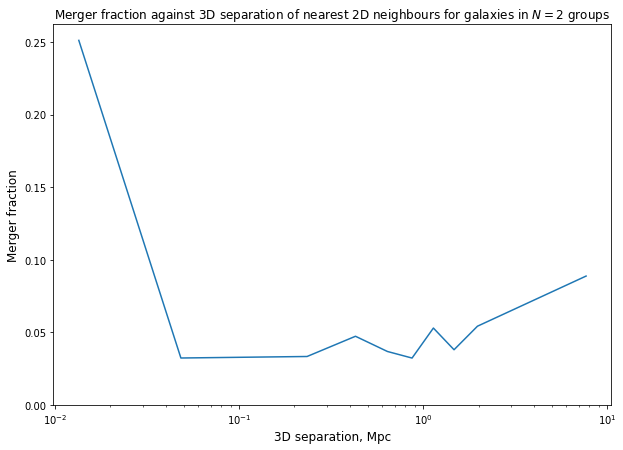

In [46]:
# Create logarithmic bins of equal size without small groups
separation_3d = n_equals_2_groups["Nearest_neighbour_separation_3d"]
equal_log_bins = pd.qcut(x=np.log10(separation_3d), q=10, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
# equal_log_bins = np.round(equal_log_bins, 0)

# Print the bins that have been calculated
print("Bins: " + str(equal_log_bins))


# plt.figure(figsize=(12,8))
# # Plot histogram of group size using logarithmic bins
# plt.hist(separation_3d, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
# plt.xscale("log")
# # plt.yscale("log")
# plt.ylim(bottom=0)
# plt.xlabel("Size of group", fontsize=12)
# plt.ylabel("Number of galaxies", fontsize=12)
# plt.title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)
# plt.show()


# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_separation_3d_binning(limited_data, separation_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Nearest_neighbour_separation_3d", "Merger_classifications", "group_id_new"]]
    
    groups_unique = limited_data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Nearest_neighbour_separation_3d"], bins=separation_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["Nearest_neighbour_separation_3d"], bins=separation_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Nearest_neighbour_separation_3d"], bins=separation_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    bin_edges[-1] += 1
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Nearest_neighbour_separation_3d"] >= bin_edges[i]) & (limited_data["Nearest_neighbour_separation_3d"] < bin_edges[i + 1])]["Nearest_neighbour_separation_3d"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_separation_3d, separation_3d_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_separation_3d_binning(n_equals_2_groups, equal_log_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_separation_3d_info = list(zip(separation_3d_bin_centres, merger_fraction_separation_3d, galaxies_in_bin, groups_in_bin))
merger_fraction_separation_3d_info_df = pd.DataFrame(merger_fraction_separation_3d_info, columns=["Average separation in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"])
display(merger_fraction_separation_3d_info_df)


plt.figure(figsize=(10,7))
plt.plot(separation_3d_bin_centres, merger_fraction_separation_3d, label="Data")
# plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.3)
# plt.axhline(y=merger_fraction_groups[0], linestyle=(0, (5, 10)), c="red", label="Field value")
plt.xscale("log")
# plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction against 3D separation of nearest 2D neighbours for galaxies in $N=2$ groups", fontsize=12)

plt.show()

## $N=3$ groups separation

We now do the same analysis as above, but for galaxies in $N=3$ groups.

In [48]:
# Select only N=2 groups
n_equals_3_groups = volume_limited_data[volume_limited_data["volume_limited_galaxies_in_group"] == 3][["galaxy ID", "group_id_new", "ra_galaxy", "dec_galaxy", "Best_redshift_new", "Merger_classifications"]].copy()
n_equals_3_groups = n_equals_3_groups.reset_index()
n_equals_3_groups["Distance"] = Planck18_arXiv_v2.comoving_distance(n_equals_3_groups["Best_redshift_new"]).value

# Add the new desired columns to the DataFrame
n_equals_3_groups["Nearest_neighbour_separation_2d_working"] = 0
n_equals_3_groups["Nearest_galaxy_id"] = 0
n_equals_3_groups["Nearest_neighbour_separation_2d"] = 0
n_equals_3_groups["Nearest_neighbour_separation_3d"] = 0

# Print the number of groups the calculation must be done for
print("Number of galaxies to calculate for: " + str(len(n_equals_3_groups)))

for i in range(len(n_equals_3_groups)):
    
    galaxy_i = pd.DataFrame(n_equals_3_groups.loc[i]).transpose()
    galaxy_i_sky_coord = SkyCoord(ra=galaxy_i["ra_galaxy"].values*u.degree, dec=galaxy_i["dec_galaxy"].values*u.degree, distance=galaxy_i["Distance"].values*u.Mpc)
    
    n_equals_3_groups.loc[~n_equals_3_groups.index.isin([i]), "Nearest_neighbour_separation_2d_working"] = galaxy_i_sky_coord.separation( SkyCoord(ra=n_equals_3_groups.loc[~n_equals_3_groups.index.isin([i]), "ra_galaxy"].values*u.degree, dec=n_equals_3_groups.loc[~n_equals_3_groups.index.isin([i]), "dec_galaxy"].values*u.degree) ).to(u.arcsecond).value
    
    not_galaxy_i = n_equals_3_groups.loc[~n_equals_3_groups.index.isin([i])]
    min_index = not_galaxy_i.loc[not_galaxy_i["Nearest_neighbour_separation_2d_working"] == not_galaxy_i["Nearest_neighbour_separation_2d_working"].min()].index
    
    n_equals_3_groups.loc[i, "Nearest_galaxy_id"] = n_equals_3_groups.loc[min_index, "galaxy ID"].values
    n_equals_3_groups.loc[i, "Nearest_neighbour_separation_2d"] = n_equals_3_groups.loc[min_index, "Nearest_neighbour_separation_2d_working"].values
    min_sep_sky_coord = SkyCoord(ra=n_equals_3_groups.loc[min_index, "ra_galaxy"].values*u.degree, dec=n_equals_3_groups.loc[min_index, "dec_galaxy"].values*u.degree, distance=n_equals_3_groups.loc[min_index, "Distance"].values*u.Mpc)
    n_equals_3_groups.loc[i, "Nearest_neighbour_separation_3d"] = galaxy_i_sky_coord.separation_3d(min_sep_sky_coord).to(u.Mpc).value
    
    # Progress checker
    if i % 2000 == 0:
        print("Progress: " + str(i) + " galaxies done")
    elif i == (len(n_equals_3_groups) - 1):
        print("Progress: Done")
    i += 1

Number of galaxies to calculate for: 3399
Progress: 0 galaxies done
Progress: 2000 galaxies done
Progress: Done


### Histograms of 2D/3D separation

We plot histograms of the calculated 2d and 3d separations to get an idea of how separations are spread.

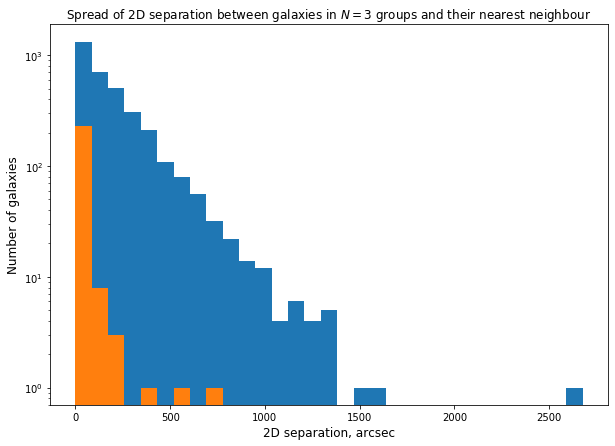

In [53]:
plt.figure(figsize=(10,7))
bins_2d = np.arange(0, 1.05, 1 / 30) * max(n_equals_3_groups["Nearest_neighbour_separation_2d"])
plt.hist(n_equals_3_groups["Nearest_neighbour_separation_2d"], bins=bins_2d, label="All N=3 galaxies")
plt.hist(n_equals_3_groups[n_equals_3_groups["Merger_classifications"] > 0]["Nearest_neighbour_separation_2d"], bins=bins_2d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("2D separation, arcsec", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 2D separation between galaxies in $N=3$ groups and their nearest neighbour", fontsize=12)
plt.show()

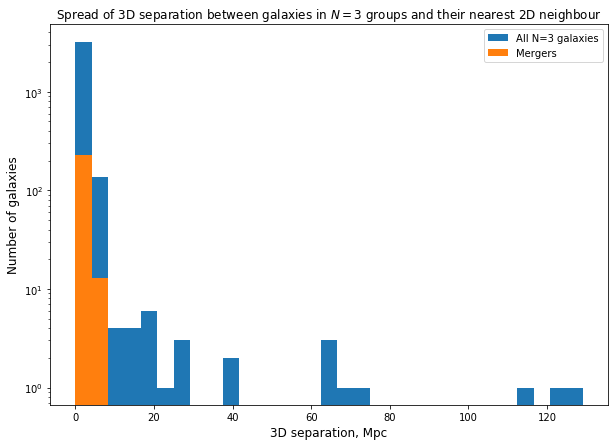

In [52]:
plt.figure(figsize=(10,7))
bins_3d = np.arange(0, 1.05, 1 / 30) * max(n_equals_3_groups["Nearest_neighbour_separation_3d"])
plt.hist(n_equals_3_groups["Nearest_neighbour_separation_3d"], bins=bins_3d, label="All N=3 galaxies")
plt.hist(n_equals_3_groups[n_equals_3_groups["Merger_classifications"] > 0]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 3D separation between galaxies in $N=3$ groups and their nearest 2D neighbour", fontsize=12)
plt.legend()
plt.show()

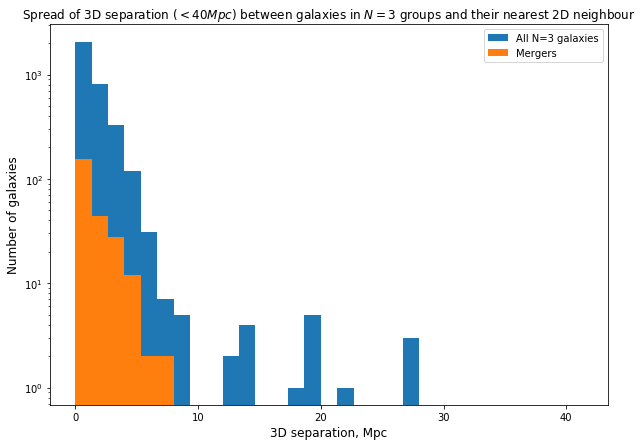

In [51]:
plt.figure(figsize=(10,7))
bins_3d = np.arange(0, 1.05, 1 / 30) * 40
plt.hist(n_equals_3_groups[n_equals_3_groups["Nearest_neighbour_separation_3d"] < 40]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="All N=3 galaxies")
plt.hist(n_equals_3_groups[(n_equals_3_groups["Nearest_neighbour_separation_3d"] < 40) & (n_equals_3_groups["Merger_classifications"] > 0)]["Nearest_neighbour_separation_3d"], bins=bins_3d, label="Mergers")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Number of galaxies", fontsize=12)
plt.title("Spread of 3D separation ($< 40 Mpc$) between galaxies in $N=3$ groups and their nearest 2D neighbour", fontsize=12)
plt.legend()
plt.show()

## Merger fraction vs 2D separation

We now calculate hwo the merger fraction changes with the 2D separation between galaxies in $N=3$ groups.

Bins: [8.76486270e-03 1.60568742e+01 3.50506094e+01 5.70250208e+01
 8.93532573e+01 1.26570157e+02 1.74139947e+02 2.24788466e+02
 3.06635537e+02 4.35805240e+02 2.58996640e+03]


,Average separation in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,9.568890,0.373529,340,107
1,25.258067,0.202941,340,104
2,45.575311,0.070588,340,102
3,72.115990,0.023529,340,106
4,107.397560,0.014749,339,113
5,148.748060,0.008824,340,102
6,198.028761,0.005882,340,117
7,262.881630,0.002941,340,114
8,362.722516,0.002941,340,130
9,656.911246,0.005882,340,138


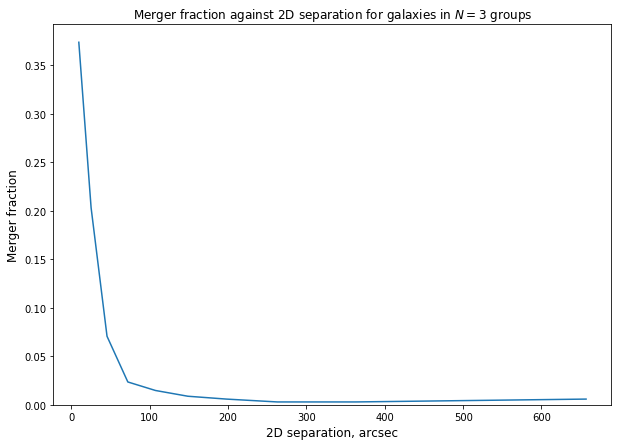

In [54]:
# Create logarithmic bins of equal size without small groups
separation_2d = n_equals_3_groups["Nearest_neighbour_separation_2d"]
equal_log_bins = pd.qcut(x=np.log10(separation_2d), q=10, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
# equal_log_bins = np.round(equal_log_bins, 0)

# Print the bins that have been calculated
print("Bins: " + str(equal_log_bins))


# plt.figure(figsize=(12,8))
# # Plot histogram of group size using logarithmic bins
# plt.hist(separation_2d, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
# plt.xscale("log")
# # plt.yscale("log")
# plt.ylim(bottom=0)
# plt.xlabel("Size of group", fontsize=12)
# plt.ylabel("Number of galaxies", fontsize=12)
# plt.title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)
# plt.show()


# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_separation_2d_binning(limited_data, separation_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Nearest_neighbour_separation_2d", "Merger_classifications", "group_id_new"]]
    
    groups_unique = limited_data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Nearest_neighbour_separation_2d"], bins=separation_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["Nearest_neighbour_separation_2d"], bins=separation_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Nearest_neighbour_separation_2d"], bins=separation_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    bin_edges[-1] += 1
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Nearest_neighbour_separation_2d"] >= bin_edges[i]) & (limited_data["Nearest_neighbour_separation_2d"] < bin_edges[i + 1])]["Nearest_neighbour_separation_2d"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_separation_2d, separation_2d_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_separation_2d_binning(n_equals_3_groups, equal_log_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_separation_2d_info = list(zip(separation_2d_bin_centres, merger_fraction_separation_2d, galaxies_in_bin, groups_in_bin))
merger_fraction_separation_2d_info_df = pd.DataFrame(merger_fraction_separation_2d_info, columns=["Average separation in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"])
display(merger_fraction_separation_2d_info_df)


plt.figure(figsize=(10,7))
plt.plot(separation_2d_bin_centres, merger_fraction_separation_2d, label="Data")
# plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.3)
# plt.axhline(y=merger_fraction_groups[0], linestyle=(0, (5, 10)), c="red", label="Field value")
# plt.xscale("log")
# plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("2D separation, arcsec", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction against 2D separation for galaxies in $N=3$ groups", fontsize=12)

plt.show()

## Merger fraction vs 3D separation

We now calculate hwo the merger fraction changes with the 3D separation between galaxies in $N=3$ groups.

Bins: [4.52307158e-05 2.46740981e-02 1.84563810e-01 4.55636067e-01
 7.08220160e-01 9.62791421e-01 1.29363626e+00 1.72162754e+00
 2.33898705e+00 3.15177312e+00 1.24894408e+02]


,Average separation in bin,Merger fraction $f_m$,Galaxies in bin,Groups in bin
0,0.011630,0.261765,340,104
1,0.069870,0.044118,340,99
2,0.317618,0.041176,340,120
3,0.586267,0.035294,340,120
4,0.821693,0.032448,339,110
5,1.119378,0.038235,340,115
6,1.493261,0.058997,339,114
7,1.990439,0.055718,341,115
8,2.706674,0.055882,340,116
9,7.140352,0.088235,340,120


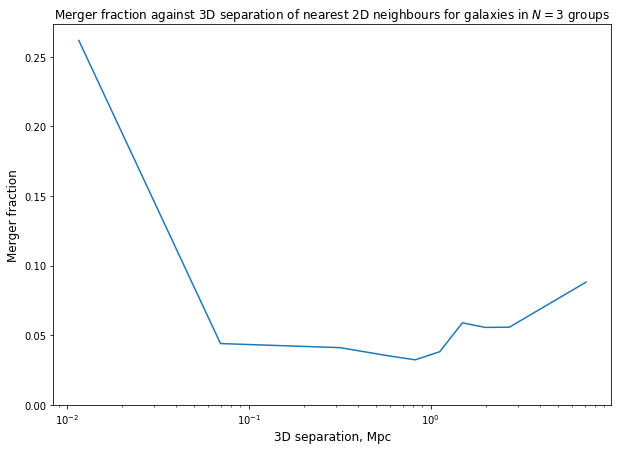

In [56]:
# Create logarithmic bins of equal size without small groups
separation_3d = n_equals_3_groups["Nearest_neighbour_separation_3d"]
equal_log_bins = pd.qcut(x=np.log10(separation_3d), q=10, labels=False, retbins=True, duplicates="drop")[1]
equal_log_bins = np.power(10, equal_log_bins)
# equal_log_bins = np.round(equal_log_bins, 0)

# Print the bins that have been calculated
print("Bins: " + str(equal_log_bins))


# plt.figure(figsize=(12,8))
# # Plot histogram of group size using logarithmic bins
# plt.hist(separation_3d, bins=equal_log_bins, edgecolor="black", histtype="stepfilled")
# plt.xscale("log")
# # plt.yscale("log")
# plt.ylim(bottom=0)
# plt.xlabel("Size of group", fontsize=12)
# plt.ylabel("Number of galaxies", fontsize=12)
# plt.title("Number of galaxies in group using equal size logarithmic bins", fontsize=12)
# plt.show()


# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_separation_3d_binning(limited_data, separation_bins):
    """Takes data, picks out mergers and calculates the merger fraction using
    the bins provided. Returns an array of merger fraction against group size,
    the average group size of galaxies in bin for plotting and the number
    of galaxies in each bin."""
    
    # Resample table with only the data needed
    limited_data = limited_data[["Nearest_neighbour_separation_3d", "Merger_classifications", "group_id_new"]]
    
    groups_unique = limited_data.drop_duplicates(subset=["group_id_new"], keep="first")
    
    # Bin data by group size, with the bin sizes specified
    allbinned, bin_edges = np.histogram(limited_data["Nearest_neighbour_separation_3d"], bins=separation_bins)
    groups_unique_binned, bin_edges = np.histogram(groups_unique["Nearest_neighbour_separation_3d"], bins=separation_bins)
    mergersbinned, bin_edges = np.histogram(limited_data[limited_data["Merger_classifications"] > 0]["Nearest_neighbour_separation_3d"], bins=separation_bins)
    
    # Calculate the average group size in each bin for plotting data
    bin_centres=[]
    bin_edges[-1] += 1
    for i in range(len(bin_edges) - 1):
        bin_centres.append(limited_data[(limited_data["Nearest_neighbour_separation_3d"] >= bin_edges[i]) & (limited_data["Nearest_neighbour_separation_3d"] < bin_edges[i + 1])]["Nearest_neighbour_separation_3d"].mean())
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # Find merger fraction
    merger_fraction_group = mergersbinned / allbinned
    
    return merger_fraction_group, bin_centres, allbinned.astype(int), groups_unique_binned.astype(int)

# Call function with all_data and calculated logarithmic bins
merger_fraction_separation_3d, separation_3d_bin_centres, galaxies_in_bin, groups_in_bin = merger_fraction_separation_3d_binning(n_equals_3_groups, equal_log_bins)

# Create dataframe of average group size, merger fraction and gaalxies in each bin and display it
merger_fraction_separation_3d_info = list(zip(separation_3d_bin_centres, merger_fraction_separation_3d, galaxies_in_bin, groups_in_bin))
merger_fraction_separation_3d_info_df = pd.DataFrame(merger_fraction_separation_3d_info, columns=["Average separation in bin", "Merger fraction $f_m$", "Galaxies in bin", "Groups in bin"])
display(merger_fraction_separation_3d_info_df)


plt.figure(figsize=(10,7))
plt.plot(separation_3d_bin_centres, merger_fraction_separation_3d, label="Data")
# plt.fill_between(group_size_bin_centres[1:], merger_fraction_group_size_bootstrapped_min[1:], merger_fraction_group_size_bootstrapped_max[1:], alpha=0.3)
# plt.axhline(y=merger_fraction_groups[0], linestyle=(0, (5, 10)), c="red", label="Field value")
plt.xscale("log")
# plt.xlim(left=1)
plt.ylim(bottom=0)
plt.xlabel("3D separation, Mpc", fontsize=12)
plt.ylabel("Merger fraction", fontsize=12)
plt.title("Merger fraction against 3D separation of nearest 2D neighbours for galaxies in $N=3$ groups", fontsize=12)

plt.show()